Isolated pixels, small islands and boundary pixels are removed;
Use spherical K-means

Treat NGC and SGC separately

In [1]:
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import sys, os, time
import fitsio
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy import units as u

from sklearn import cluster
from spherecluster import SphericalKMeans
sys.path.append('/Users/roz18/git/pixel_partition')
import pp_modules

In [2]:
# Parameters
min_neighbors = 7
min_island_size = 100

In [3]:
print('############## Loading randoms ##############')
randoms = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000.fits'),
                     columns=['RA', 'DEC', 'MASKBITS'])

# BRIGHTSTARINBLOB mask
blobmask_bad = (randoms['MASKBITS'] & 2**1 > 0)
print('Fraction of objects masked by BRIGHTSTARINBLOB: {:.2f}%'.format(np.sum(blobmask_bad)/len(blobmask_bad)*100))

# WISE geometric mask
catmask = fitsio.read(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_wisemask.fits'),
                     columns=['wisemask'])
catmask_bad = np.copy(catmask['wisemask'])
print('Fraction of objects masked by geometric WISE mask: {:.2f}%'.format(np.sum(catmask_bad)/len(catmask_bad)*100))

# WISE pixel mask: "not-primary" and "resolved galaxy" are not used
pixmask = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/catalogs/dr7.1/randoms/randoms-dr7-trim-10000_pixmask.npy'))
pixmask_bad = (pixmask!=0) & (pixmask!=(2**6)) & (pixmask!=(2**9))
print('Fraction of objects masked by pixel WISE mask: {:.2f}%'.format(np.sum(pixmask_bad)/len(pixmask_bad)*100))

# Remove potentially bad regions
nside = 128
bad_pix_list = np.load(os.path.join(os.getenv('DATA_PATH'), 'desi_photoz/dr7/other_masks/dr7_photo-z_outliers_in_dbscan_clusters_aggressive_hp_128_list_20181102.npy'))
npix = hp.nside2npix(nside)
pix = hp.pixelfunc.ang2pix(nside, randoms['RA'], randoms['DEC'], lonlat=True)
healpix_bad = np.in1d(pix, bad_pix_list)
print('Fraction of objects masked by healpix mask: {:.2f}%'.format(np.sum(healpix_bad)/len(healpix_bad)*100))

mask_bad = blobmask_bad | catmask_bad | pixmask_bad | healpix_bad
print('BRIGHTSTARINBLOB + WISE geometric + WISE pixel + healpix')
print('Fraction of masked objects: {:.2f}%'.format(np.sum(mask_bad)/len(mask_bad)*100))

randoms = randoms[~mask_bad]
print(len(randoms))

########################## Additional cuts ##########################

ra = np.copy(randoms['RA'])
dec = np.copy(randoms['DEC'])

########### Cut on Galactic latitude ###########

# Convert to the Galactic coordinates
c = SkyCoord(ra=ra*u.degree, dec=dec*u.degree, frame='icrs')
temp = c.galactic
l, b = np.array(temp.l), np.array(temp.b)

mask_remove = np.abs(b)<25

########### Remove regions with no-so-clean photometry ###########

mask = (ra>30) & (ra<80) & (dec>-7.5)
mask_remove |= mask
mask = (ra<100) & (dec>5)
mask_remove |= mask
mask = (ra<15) & (dec>-14) & (dec<-7.5)
mask_remove |= mask
mask = (ra>300) & (dec>12)
mask_remove |= mask

print('Fraction of objects removed by additional footprint cuts: {:.2f}%'.format(np.sum(mask_remove)/len(mask_remove)*100))
randoms = randoms[~mask_remove]
print(len(randoms))

############## Loading randoms ##############
Fraction of objects masked by BRIGHTSTARINBLOB: 0.95%
Fraction of objects masked by geometric WISE mask: 2.71%
Fraction of objects masked by pixel WISE mask: 2.36%
Fraction of objects masked by healpix mask: 0.82%
BRIGHTSTARINBLOB + WISE geometric + WISE pixel + healpix
Fraction of masked objects: 5.04%
68169943
Fraction of objects removed by additional footprint cuts: 14.73%
58127753


In [4]:
area = len(randoms)/10000
print('Area = {:.1f} sq deg'.format(area))

Area = 5812.8 sq deg


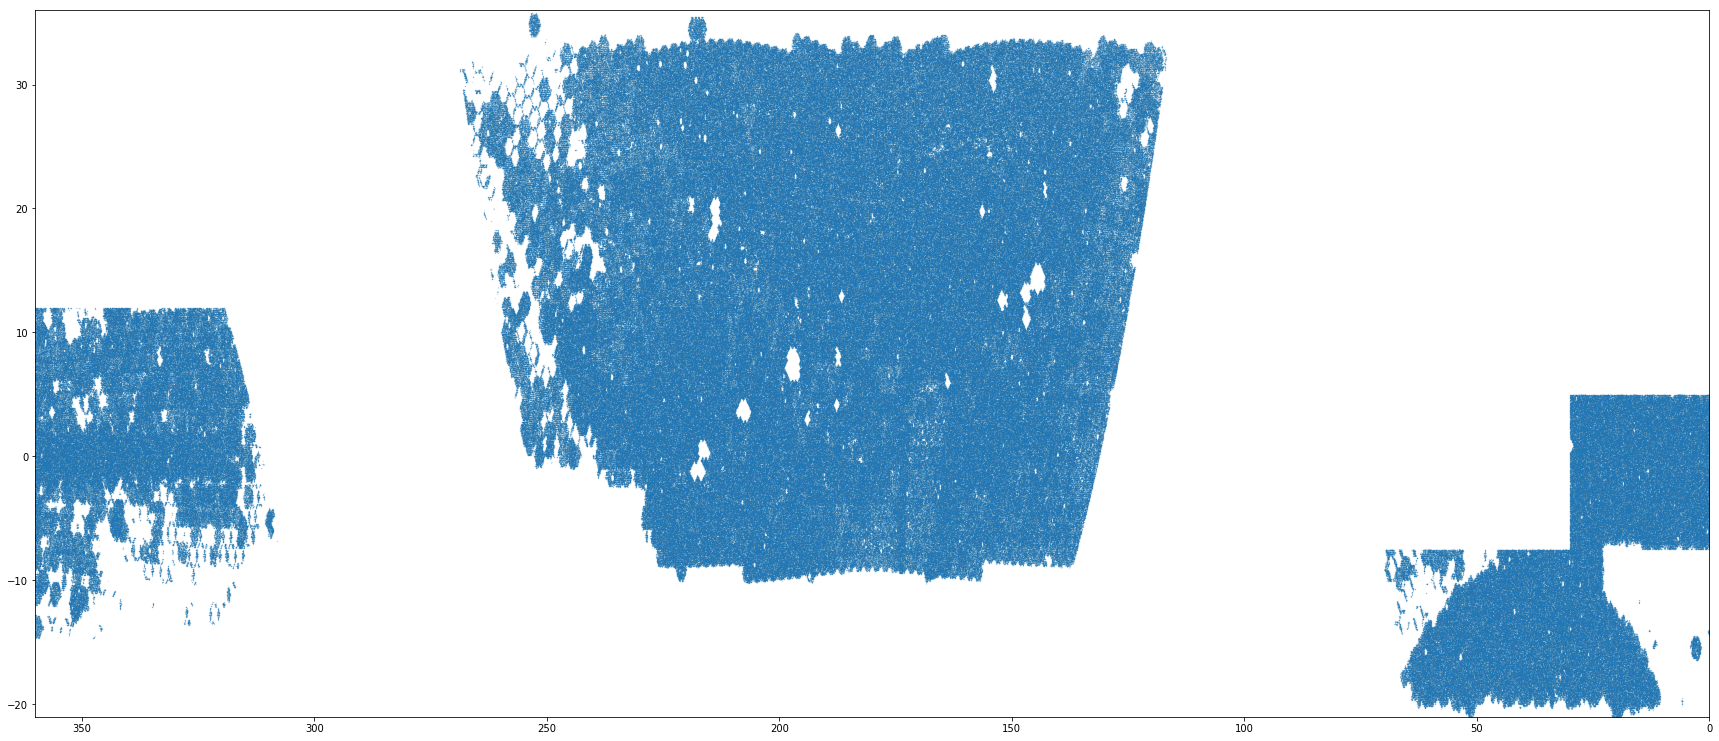

In [5]:
idx = np.random.choice(len(randoms), len(randoms)//20, replace=False)
plt.figure(figsize=(30, 13))
plt.plot(randoms['RA'][idx], randoms['DEC'][idx], '.', markersize=0.3, alpha=0.5)
plt.axis([360, 0, -21, 36])
plt.show()

In [6]:
NSIDE = 2**7
npix = hp.nside2npix(NSIDE)
# hp.pixelfunc.ang2pix
ra_array, dec_array = hp.pixelfunc.pix2ang(NSIDE, np.arange(npix), lonlat=True)

pix = hp.pixelfunc.ang2pix(NSIDE, randoms['RA'], randoms['DEC'], lonlat=True)
pix_unique, pix_count = np.unique(pix, return_counts=True)
m = np.zeros(npix)
m[pix_unique] = pix_count
# Convert to number density (per sq. deg.)
c = 1/(41253/npix)
m = m*c
occupied = m!=0
m_occupied = m[occupied]

ra_array = ra_array[occupied]
dec_array = dec_array[occupied]

__Remove boundary pixels__

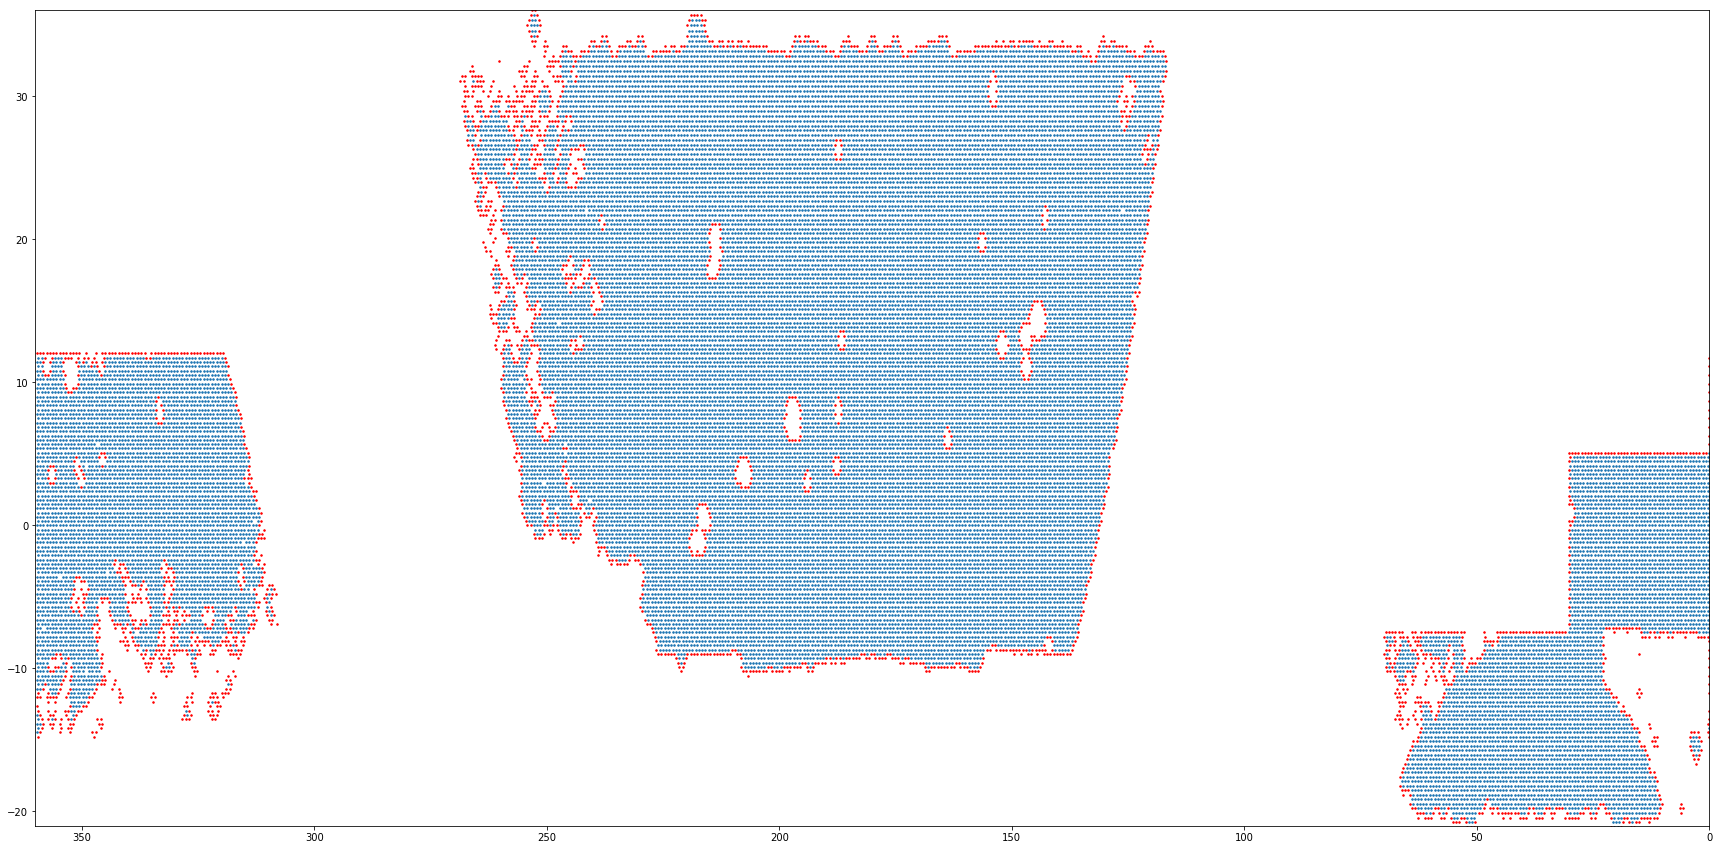

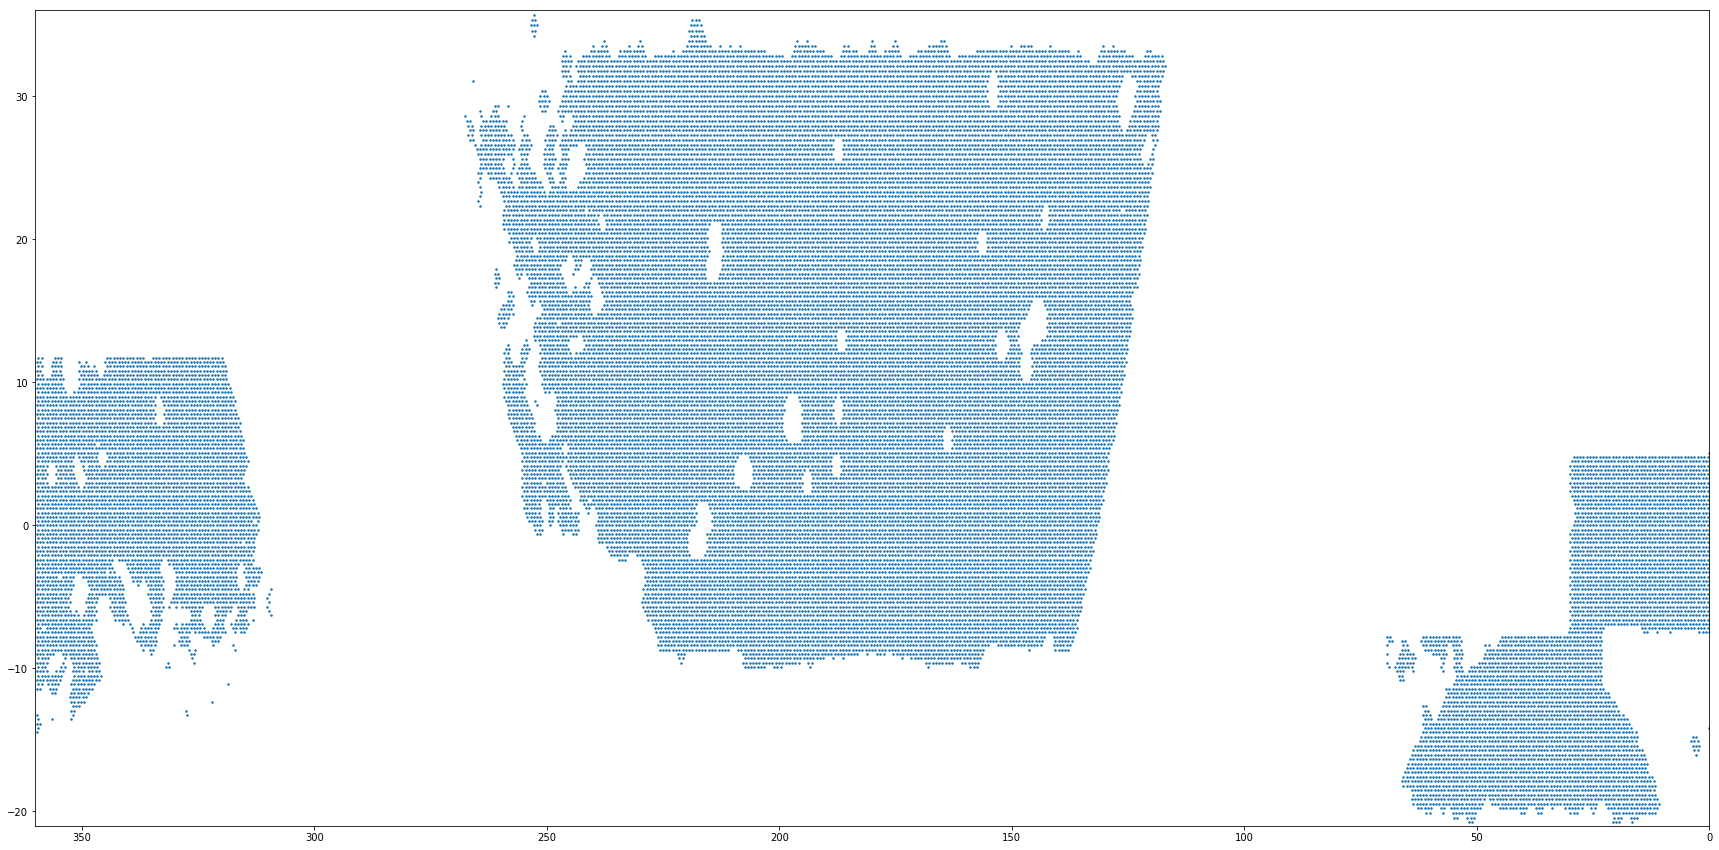

In [7]:
idx = pp_modules.find_survey_boundary(NSIDE, ra_array, dec_array, min_neighbors=min_neighbors)
hp_mask = np.ones(len(ra_array), dtype=bool)
hp_mask[idx] = False

plt.figure(figsize=(30, 15))
plt.plot(ra_array[hp_mask], dec_array[hp_mask], '.', markersize=3)
plt.plot(ra_array[~hp_mask], dec_array[~hp_mask], 'r.', markersize=3)
plt.axis([360, 0, -21, 36])
plt.show()

plt.figure(figsize=(30, 15))
plt.plot(ra_array[hp_mask], dec_array[hp_mask], '.', markersize=3)
plt.axis([360, 0, -21, 36])
plt.show()

34230 occupied heapix pixels
58127753 objects


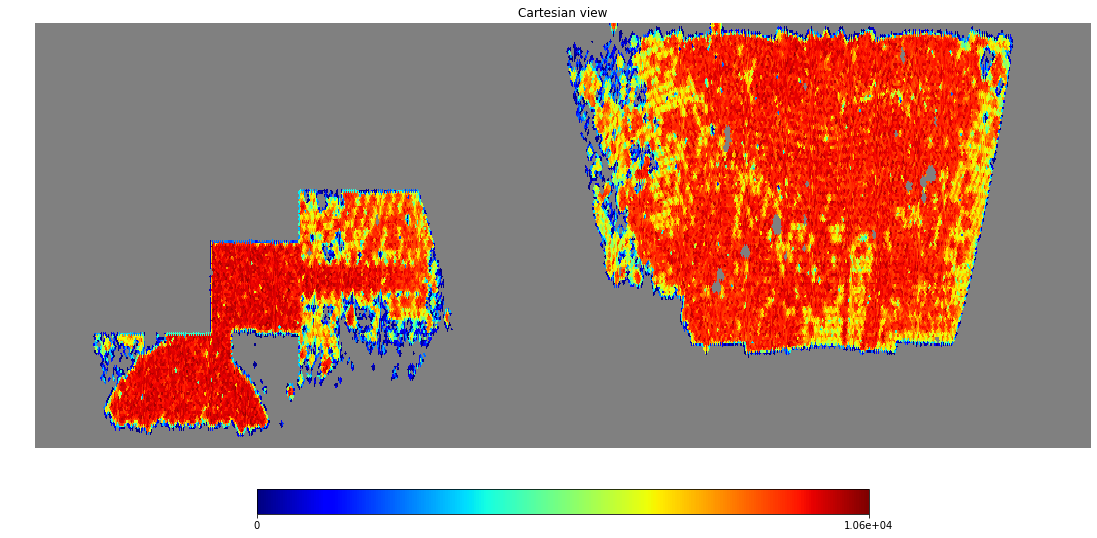

31542 (92.1%) heapix pixels after the cut
56729813 objects (97.6%)


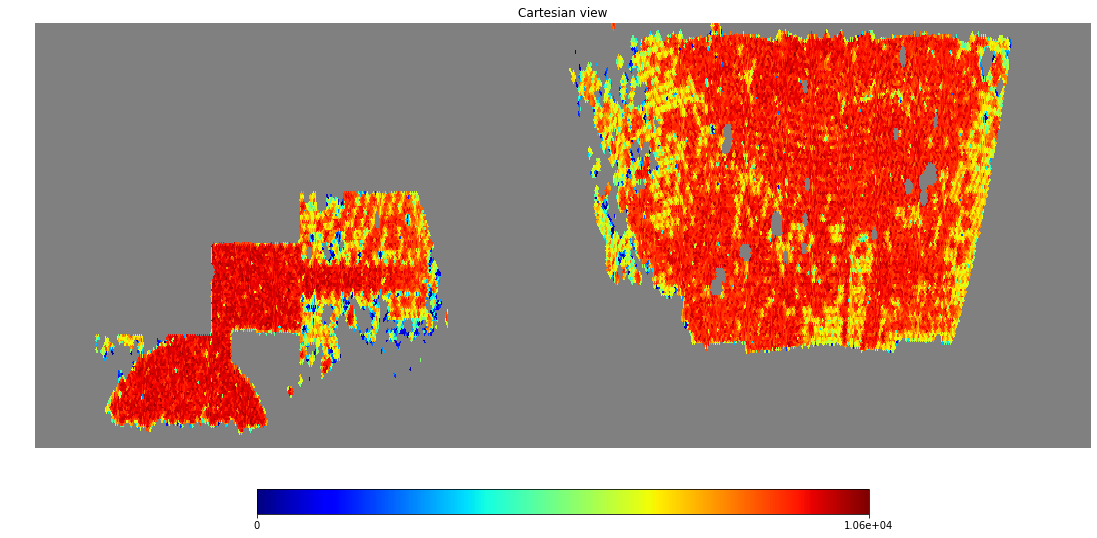

In [8]:
m_masked = hp.ma(m)
m_masked.mask = ~occupied

# plt.hist(m[occupied], 50)
# plt.show()

print(np.sum(occupied), 'occupied heapix pixels')
print(int(np.sum(m[occupied])/c), 'objects')

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-23, 35), aspect=2.5, xsize=2000)
plt.show()

nobj0 = int(np.sum(m_occupied)/c)
nobj = int(np.sum(m_occupied[hp_mask])/c)
m_final = m_occupied[hp_mask]

m_masked = hp.ma(m)
m_masked.mask = np.ones(len(m), dtype=bool)
m_masked.mask &= (~occupied)
m_masked.mask[occupied] = (~hp_mask)

print('{} ({:.1f}%) heapix pixels after the cut'
     .format(np.sum(hp_mask), np.sum(hp_mask)/np.sum(occupied)*100, ))
print('{} objects ({:.1f}%)'.format(nobj, nobj/nobj0*100))

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-23, 35), aspect=2.5, xsize=2000)
plt.show()

__Remove small islands__

In [9]:
# reload(pp_modules)

In [10]:
island_labels = pp_modules.identify_islands(NSIDE, ra_array[hp_mask], dec_array[hp_mask])

n_island = len(np.unique(island_labels))
island_sizes = np.zeros(np.sum(hp_mask))
for index in range(n_island):
    mask = island_labels == index
    island_sizes[mask] = np.sum(mask)    

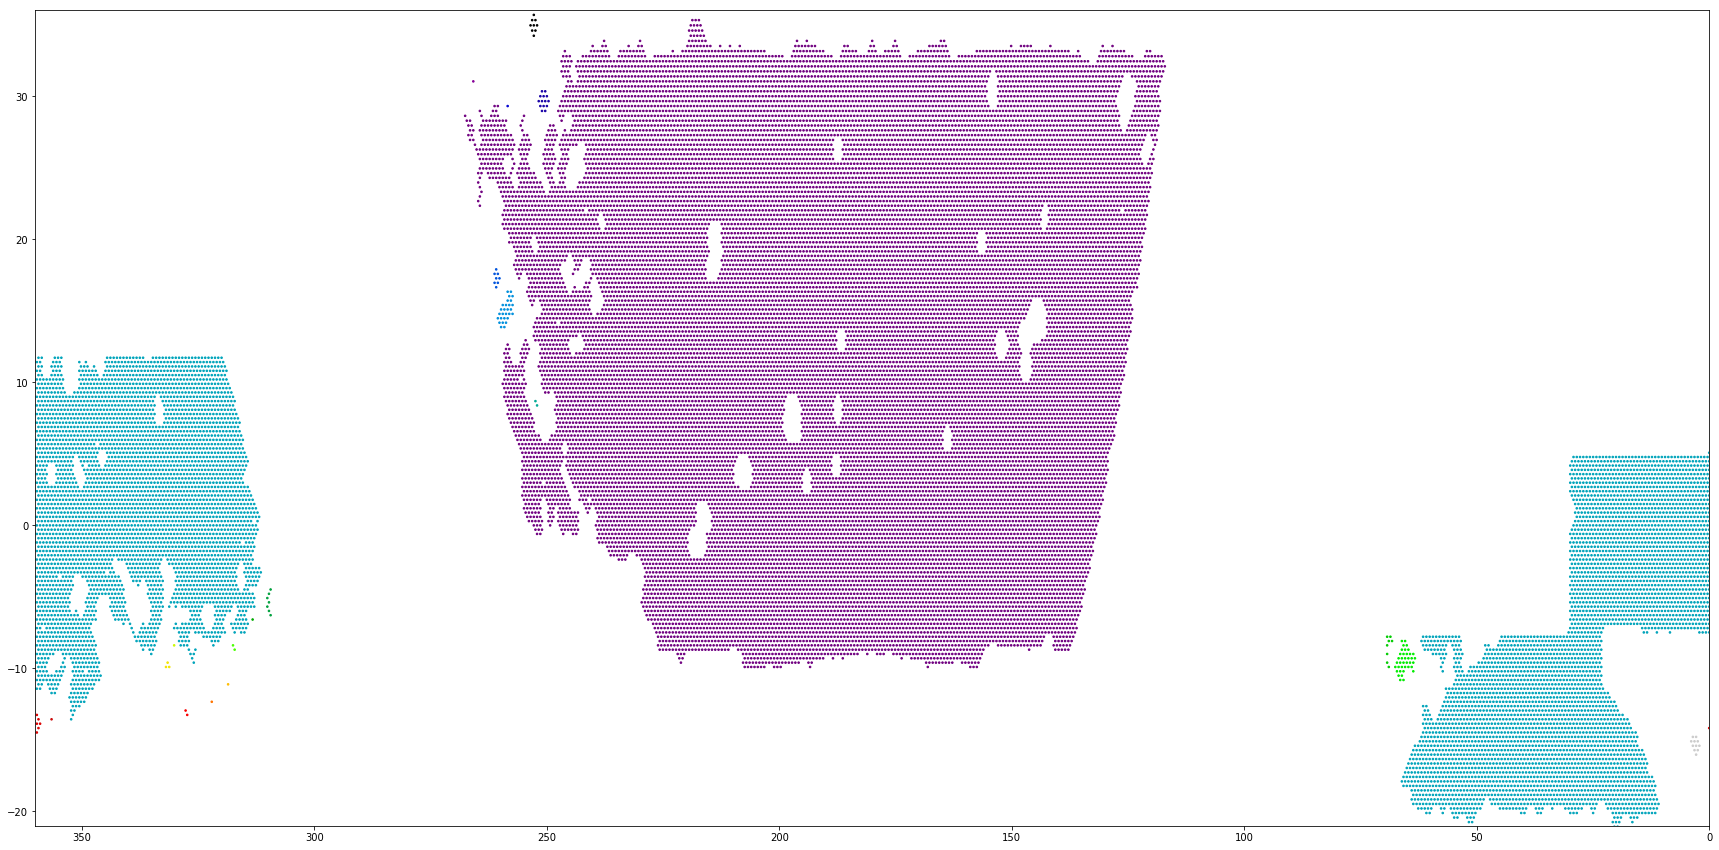

31396 (91.7%) heapix pixels after the cut
56553716 objects (97.3%)


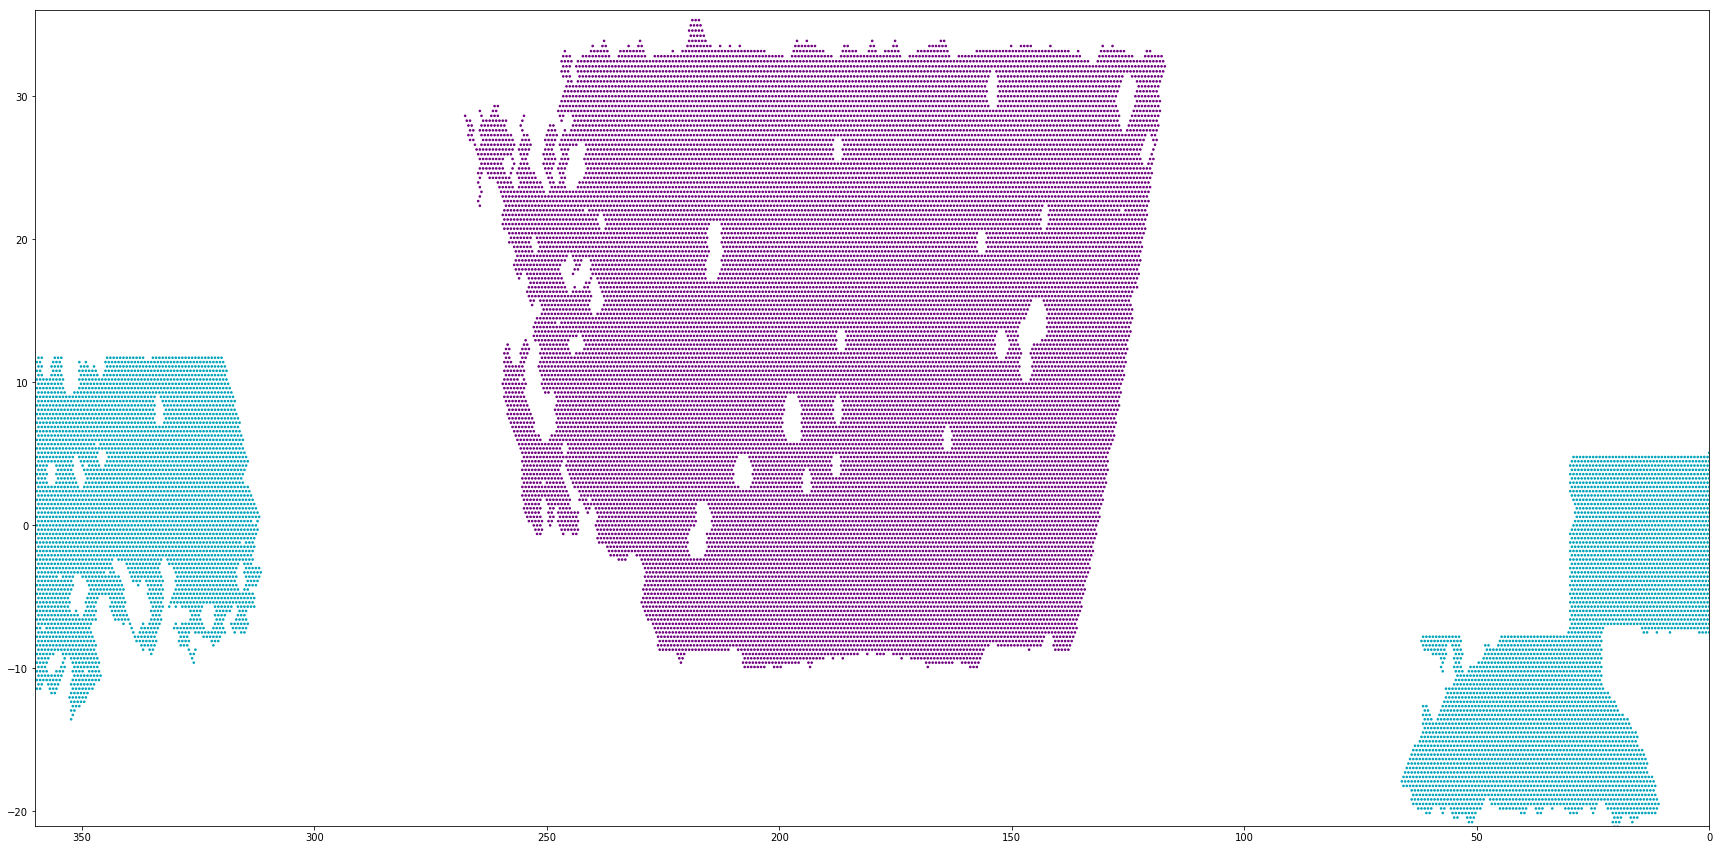

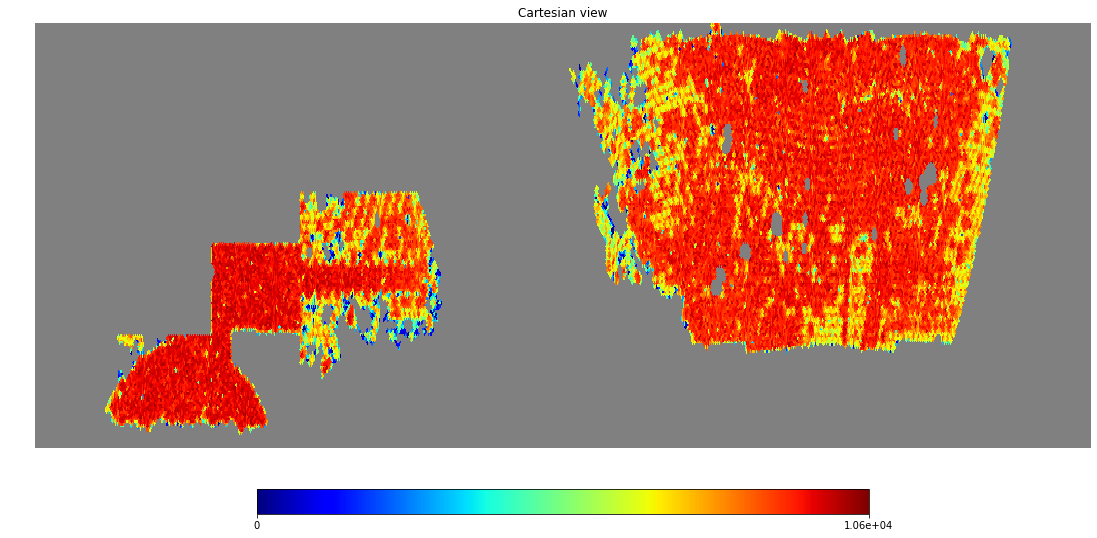

In [11]:
plt.figure(figsize=(30, 15))
plt.scatter(ra_array[hp_mask], dec_array[hp_mask], c=island_labels, edgecolor=None, cmap='nipy_spectral', s=2.5)
plt.axis([360, 0, -21, 36])
plt.show()

mask = island_sizes >= min_island_size
nobj = int(np.sum(m_occupied[hp_mask][mask])/c)

print('{} ({:.1f}%) heapix pixels after the cut'
     .format(np.sum(mask), np.sum(mask)/np.sum(occupied)*100, ))
print('{} objects ({:.1f}%)'.format(nobj, nobj/nobj0*100))

plt.figure(figsize=(30, 15))
plt.scatter(ra_array[hp_mask][mask], dec_array[hp_mask][mask], c=island_labels[mask], edgecolor=None, s=2.5, cmap='nipy_spectral', vmin=island_labels.min(), vmax=island_labels.max())
plt.axis([360, 0, -21, 36])
plt.show()

hp_mask1 = np.copy(hp_mask)
hp_mask1[hp_mask1] = mask
m_masked = hp.ma(m)
m_masked.mask = np.ones(len(m), dtype=bool)
m_masked.mask &= (~occupied)
m_masked.mask[occupied] = (~hp_mask1)

plt.rcParams['image.cmap'] = 'jet'
plt.figure(figsize=(20, 8))
hp.cartview(m_masked, min=0, rot=(-90, 0, 0), fig=1, latra=(-23, 35), aspect=2.5, xsize=2000)
plt.show()

__Add weights to pixels by generating more pixels at the same spot__

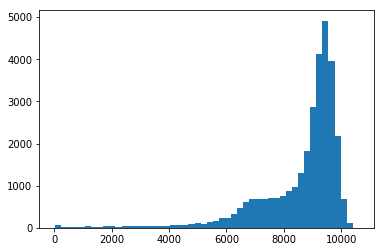

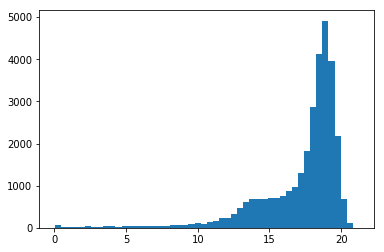

In [12]:
m_final = m_occupied[hp_mask1]
plt.hist(m_final, 50)
plt.show()

plt.hist(m_final/500, 50)
plt.show()

In [13]:
ra0 = ra_array[hp_mask1]
dec0 = dec_array[hp_mask1]

In [14]:
n_clusters = 120

# Average number of objects per group
n_average = np.sum(m_final)/c/n_clusters

mask_sgc = (ra0>300) | (ra0<100)
print('Groups in SGC:', np.sum(m_final[mask_sgc])/c/n_average)
mask_ngc = ~mask_sgc
print('Groups in NGC:', np.sum(m_final[mask_ngc])/c/n_average)

Groups in SGC: 31.00325927300692
Groups in NGC: 88.99674072699308


In [15]:
n_clusters_sgc = 31
n_clusters_ngc = 89

## Spherical K-means clustering

### SGC

In [26]:
# Duplicate points as a way of assigning weights
ra = np.copy(ra0[mask_sgc])
dec = np.copy(dec0[mask_sgc])
for i in range(1, 40):
    mask = np.round(m_final[mask_sgc]/500.)==i
    for j in range(i-1): # i-1 because there is already one copy
        ra = np.concatenate([ra, ra0[mask_sgc][mask]])
        dec = np.concatenate([dec, dec0[mask_sgc][mask]])

In [27]:
print(len(ra0[mask_sgc]))
print(len(ra))

8230
139306


In [28]:
x = np.cos(dec/180.*np.pi) * np.cos(ra/180.*np.pi)
y = np.cos(dec/180.*np.pi) * np.sin(ra/180.*np.pi)
z = np.sin(dec/180.*np.pi)

coords = np.column_stack([x, y, z])
print(len(coords))

139306


In [29]:
skmeans = SphericalKMeans(n_clusters=n_clusters_sgc, n_init=10, init='random')

t0 = time.time()
skmeans.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

skm_labels_sgc = skmeans.labels_[:np.sum(mask_sgc)]

time 31.20s


### NGC

In [20]:
# Duplicate points as a way of assigning weights
ra = np.copy(ra0[mask_ngc])
dec = np.copy(dec0[mask_ngc])
for i in range(1, 40):
    mask = np.round(m_final[mask_ngc]/500.)==i
    for j in range(i-1): # i-1 because there is already one copy
        ra = np.concatenate([ra, ra0[mask_ngc][mask]])
        dec = np.concatenate([dec, dec0[mask_ngc][mask]])

In [21]:
print(len(ra0[mask_ngc]))
print(len(ra))

23166
399887


In [22]:
x = np.cos(dec/180.*np.pi) * np.cos(ra/180.*np.pi)
y = np.cos(dec/180.*np.pi) * np.sin(ra/180.*np.pi)
z = np.sin(dec/180.*np.pi)

coords = np.column_stack([x, y, z])
print(len(coords))

399887


In [23]:
skmeans = SphericalKMeans(n_clusters=n_clusters_ngc, n_init=10, init='random')

t0 = time.time()
skmeans.fit(coords)
elapsed_time = time.time() - t0
print('time %.2fs'%(elapsed_time))

skm_labels_ngc = skmeans.labels_[:np.sum(mask_ngc)]

time 432.19s


__Combined two regions__

In [30]:
skm_labels = np.zeros(len(ra0), dtype=int)
skm_labels[mask_sgc] = skm_labels_sgc
skm_labels[mask_ngc] = skm_labels_ngc + n_clusters_sgc

In [31]:
# Scramble the labels to make the plots look nicer
skm_labels1 = np.zeros(len(ra0), dtype=int)
idx = np.random.choice(n_clusters_sgc+n_clusters_ngc, size=(n_clusters_sgc+n_clusters_ngc), replace=False)
for index in range(len(idx)):
    mask = skm_labels==index
    skm_labels1[mask] = idx[index]

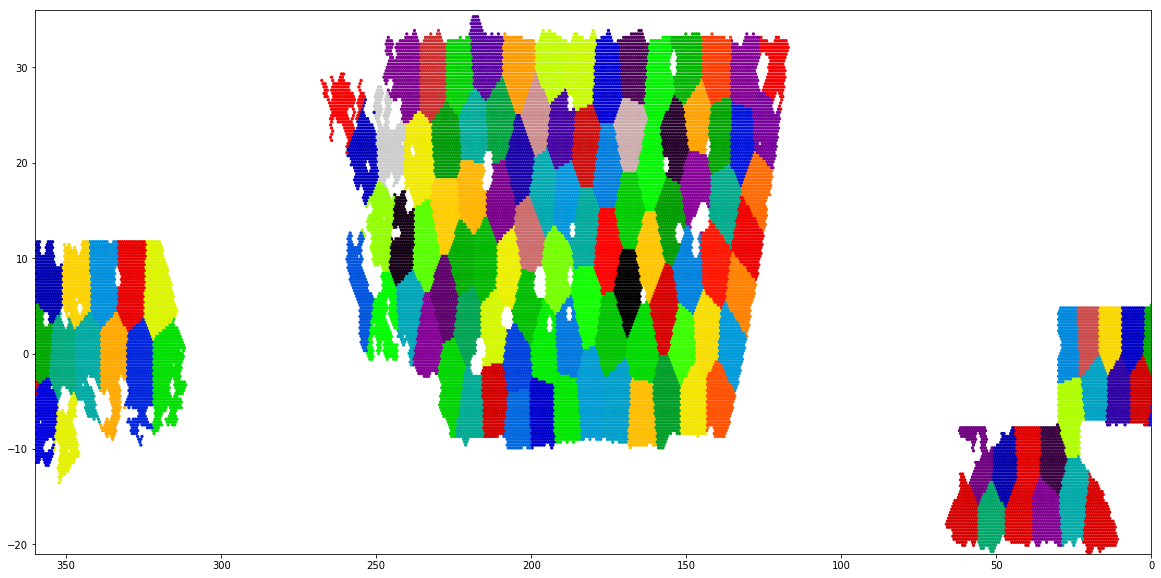

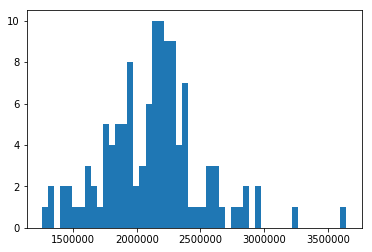

In [32]:
plt.figure(figsize=(20, 10))
plt.scatter(ra0, dec0, c=skm_labels1,
            cmap='nipy_spectral', s=5)
plt.axis([360, 0, -21, 36])
plt.show()

skm_counts = np.zeros(n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(skm_labels==idx_grp)[0]
    skm_counts[idx_grp] = np.sum(m_occupied[members])
plt.hist(skm_counts, 50)
plt.show()

/Users/roz18/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1330: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


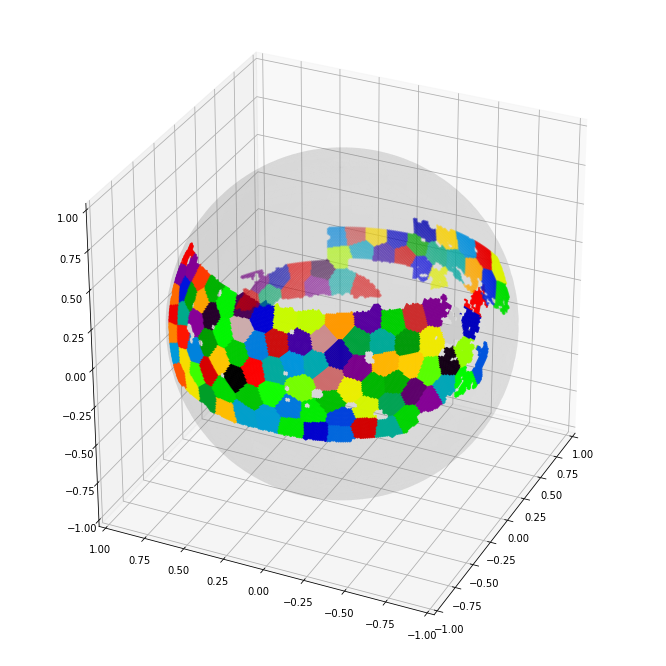

In [33]:
# 3D plot
from mpl_toolkits.mplot3d import Axes3D

u1 = np.linspace(0, 2 * np.pi, 200)
v1 = np.linspace(0, np.pi, 200)
x1 = 1 * np.outer(np.cos(u1), np.sin(v1))
y1 = 1 * np.outer(np.sin(u1), np.sin(v1))
z1 = 1 * np.outer(np.ones(np.size(u1)), np.cos(v1))

x = np.cos(dec0/180.*np.pi) * np.cos(ra0/180.*np.pi)
y = np.cos(dec0/180.*np.pi) * np.sin(ra0/180.*np.pi)
z = np.sin(dec0/180.*np.pi)

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(1, 1, 1, aspect='equal', projection='3d',
        adjustable='box-forced', xlim=[-1., 1.], ylim=[-1., 1.],
        zlim=[-1., 1.])
ax.plot_surface(x1, y1, z1,  rstride=4, cstride=4, color='gray', linewidth=0, alpha=0.1)
ax.scatter(x[:len(ra0)], y[:len(ra0)], z[:len(ra0)], 
           c=skm_labels1, cmap='nipy_spectral', s=5, lw=0)
ax.set_aspect('equal')
ax.view_init(30, 205)
plt.show()

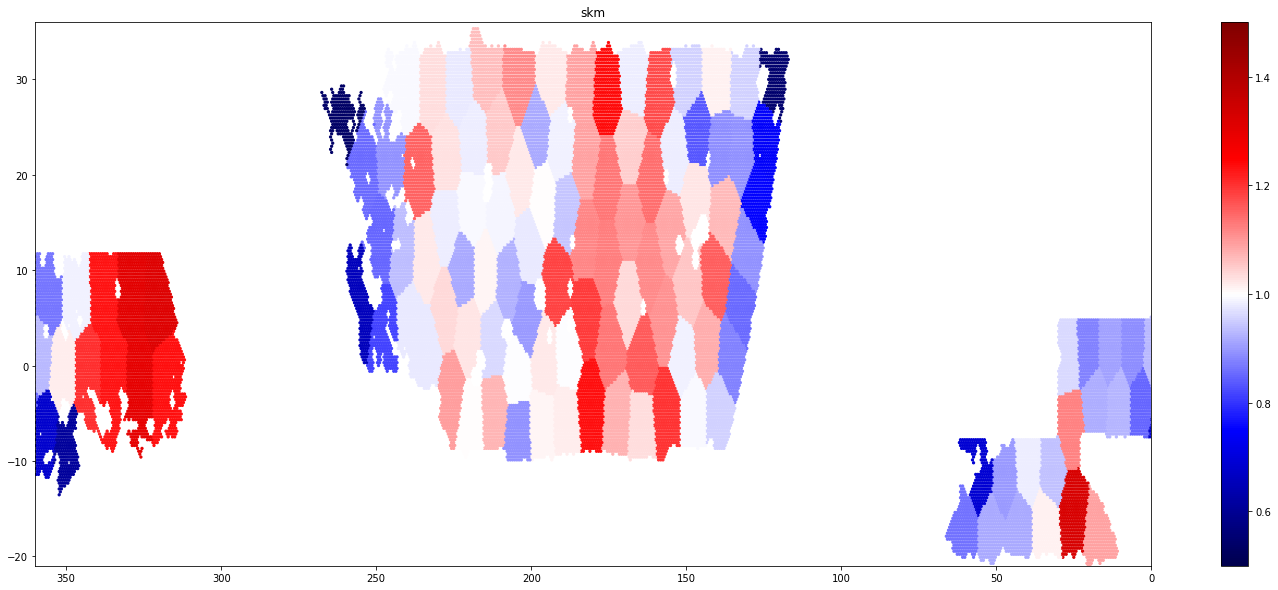

In [34]:
skm_group_counts = np.zeros(n_clusters)
average_count = np.sum(m_final/n_clusters)
for idx_grp in range(n_clusters):
    members = np.where(skm_labels==idx_grp)[0]
    skm_group_counts[idx_grp] = np.sum(m_final[members])
skm_counts_pix = skm_group_counts[skm_labels]
plt.figure(figsize=(25, 10))
plt.scatter(ra0, dec0, c=skm_counts_pix/average_count,
            cmap=plt.cm.seismic, s=5, vmin=0.5, vmax=1.5)
plt.colorbar()
plt.title('skm')
plt.axis([360, 0, -21, 36])
plt.show()

__Save clustering results__

In [37]:
t = Table()

# t['RA'] = ra1
# t['DEC'] = dec1
# t['count'] = m_occupied1/c
# t['density'] = m_occupied1
t['ra'] = ra0
t['dec'] = dec0
t['count'] = m_final/c
t['density'] = m_final
t['label'] = skm_labels
t['label_scrambled'] = skm_labels1

t.write('/Users/roz18/git/desi-photoz/dr7/clustering/jackknife_partition/results/clustering_results_20181119.txt', format='ascii.commented_header')

In [38]:
t

<Table length=31396>
        ra                 dec         ... label label_scrambled
     float64             float64       ... int64      int64     
------------------ ------------------- ... ----- ---------------
217.26562499999997   35.31877290301153 ...    46              14
217.96874999999997   35.31877290301153 ...    46              14
        218.671875   35.31877290301153 ...    46              14
       216.9140625   34.95386525718846 ...    46              14
       217.6171875   34.95386525718846 ...    46              14
218.32031249999997   34.95386525718846 ...    46              14
219.02343749999997   34.95386525718846 ...    46              14
          216.5625   34.59057497617661 ...    46              14
217.26562499999997   34.59057497617661 ...    46              14
217.96874999999997   34.59057497617661 ...    46              14
               ...                 ... ...   ...             ...
         54.140625 -20.423615363810953 ...    29              49
          54.84375 -20.423615363810953 ...    29              49
16.523437499999996 -20.742379954487134 ...    20             108
19.335937499999996 -20.742379954487134 ...    20             108
        20.0390625 -20.742379954487134 ...    20             108
        20.7421875 -20.742379954487134 ...    20             108
        50.9765625 -20.742379954487134 ...    29              49
 51.67968749999999 -20.742379954487134 ...    29              49
           19.6875  -21.06181760164931 ...    20             108
20.390624999999996  -21.06181760164931 ...    20             108